In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from tqdm import tqdm
import timm
import torchattacks
import matplotlib.pyplot as plt
import torchvision
import numpy as np
import detectors

In [2]:
norm_mean = (0.4914, 0.4822, 0.4465)
norm_std =  (0.2023, 0.1994, 0.201)

transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=norm_mean, std=norm_std)
])

batch_size = 64
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [3]:
num_classes = 10

In [4]:
# model = timm.create_model('resnet18', pretrained=True, num_classes=num_classes)
# model.load_state_dict(torch.load("cifar10_model.pth"))

In [5]:
model = timm.create_model('resnet18_cifar10', pretrained=True)

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = model.to(device)

cuda


In [7]:
eps = 0.02
fgsm = torchattacks.FGSM(model, eps=eps)
fgsm.set_normalization_used(mean=norm_mean, std=norm_std)
bim = torchattacks.BIM(model, eps=eps, alpha=0.01, steps=10)
bim.set_normalization_used(mean=norm_mean, std=norm_std)
pgd = torchattacks.PGD(model, eps=eps, alpha=0.01, steps=40)
pgd.set_normalization_used(mean=norm_mean, std=norm_std)

In [8]:
def evaluate_attack(attack, dataloader):
    model.eval()
    correct = 0
    total = 0
    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        if attack:
            adv_inputs = attack(inputs, labels)
        else:
            adv_inputs = inputs

        outputs = model(adv_inputs)
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy


In [9]:
clean_accuracy = evaluate_attack(None, testloader)
print(f'Clean data accuracy: {clean_accuracy:.2f}%')

Clean data accuracy: 94.98%


In [10]:
fgsm_accuracy = evaluate_attack(fgsm, testloader)
print(f'FGSM accuracy: {fgsm_accuracy:.2f}%')

FGSM accuracy: 30.06%


In [11]:
bim_accuracy = evaluate_attack(bim, testloader)
print(f'BIM accuracy: {bim_accuracy:.2f}%')

BIM accuracy: 0.04%


In [12]:
pgd_accuracy = evaluate_attack(pgd, testloader)
print(f'PGD accuracy: {pgd_accuracy:.2f}%')

PGD accuracy: 0.00%


In [10]:
def denormalize(img):
    img_normalized = img.clone()
    for c in range(3):
        img_normalized[c] = img[c] * norm_std[c] + norm_mean[c]
    img_normalized = torch.clamp(img_normalized, 0, 1)
    return img_normalized

In [11]:
def visualize(dataset, attack=None):
    model.eval()
    
    for img, label in dataset:
        img = img.unsqueeze(0).cuda()
        label = torch.tensor([label]).cuda()

        clean_outputs = model(img)
        _, clean_preds = torch.max(clean_outputs, 1)

        adv_images = attack(img, label) if attack is not None else img
        adv_outputs = model(adv_images)
        _, adv_preds = torch.max(adv_outputs, 1)

        mask = adv_images - img

        fig, axes = plt.subplots(1, 3, figsize=(12, 4))
        fig.subplots_adjust(wspace=0.5)

        axes[0].imshow(np.transpose(denormalize(img[0]).cpu().numpy(), (1, 2, 0)))
        axes[0].set_title(f"Clean Image\nPred: {clean_preds[0].item()}\nTrue: {label.item()}")
        axes[0].axis('off')

        axes[1].imshow(np.transpose(denormalize(adv_images[0]).cpu().numpy(), (1, 2, 0)))
        axes[1].set_title(f"Adversarial Image\nPred: {adv_preds[0].item()}")
        axes[1].axis('off')

        axes[2].imshow(np.transpose(denormalize(mask[0]).cpu().numpy(), (1, 2, 0)))
        axes[2].set_title("Perturbation (Mask)")
        axes[2].axis('off')

        plt.show()

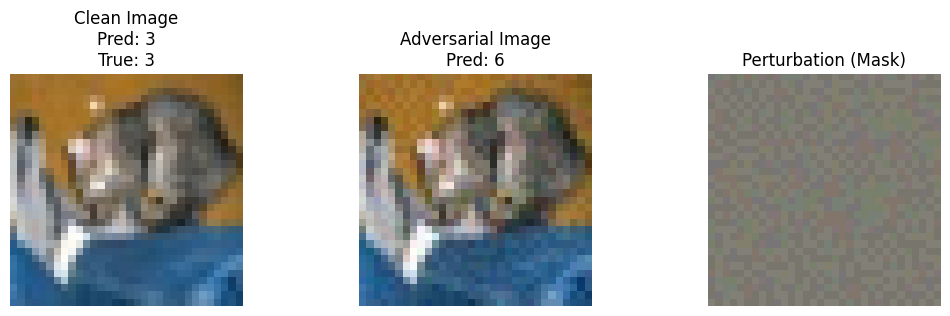

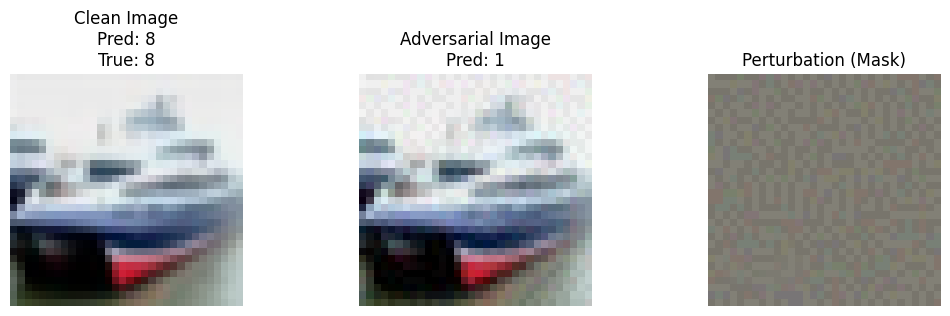

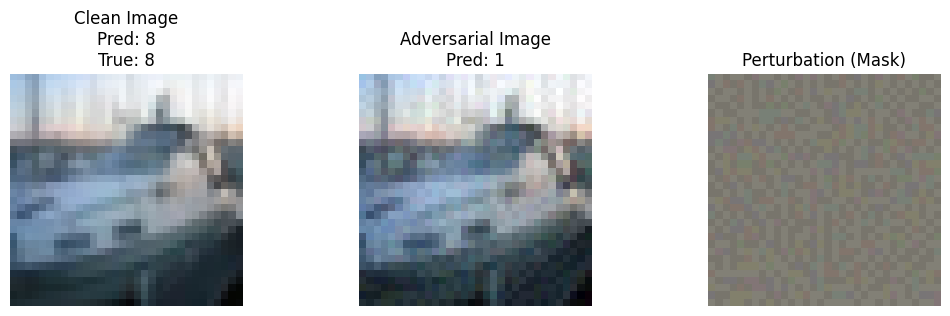

In [12]:
visualize([testset[i] for i in range(0, 3)], attack=fgsm)

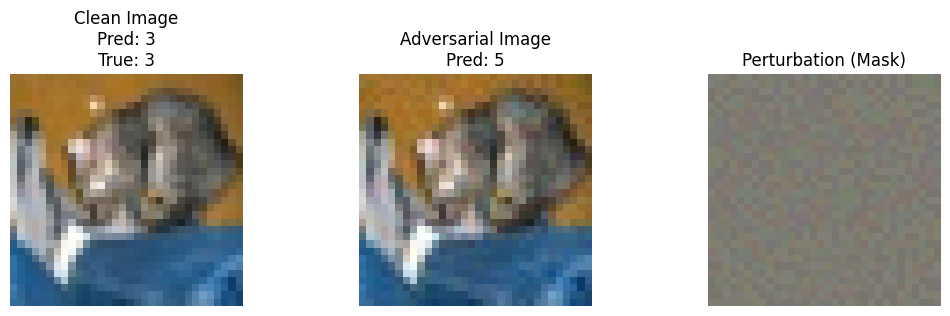

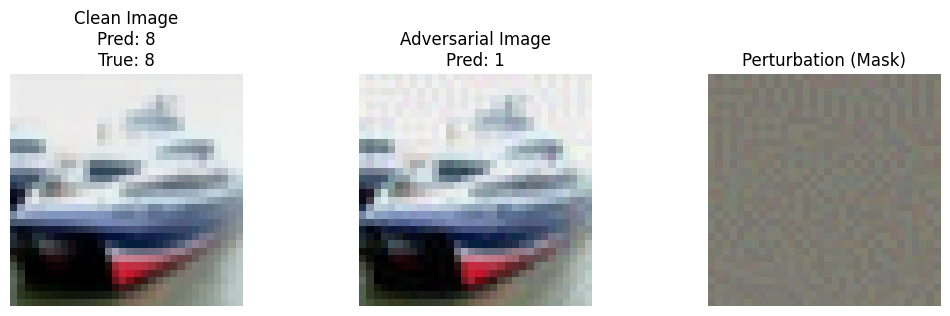

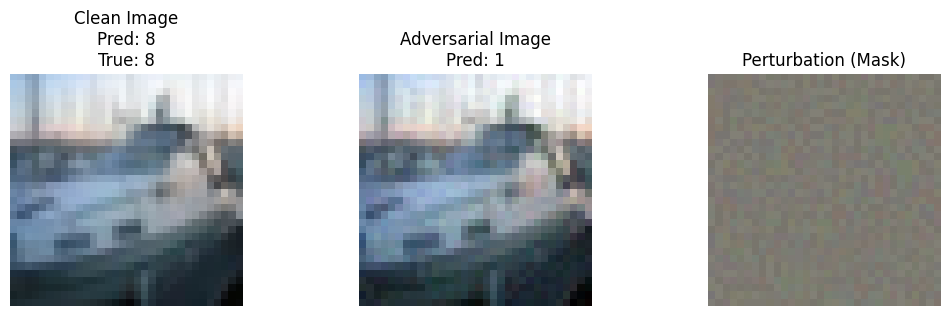

In [13]:
visualize([testset[i] for i in range(0, 3)], attack=bim)

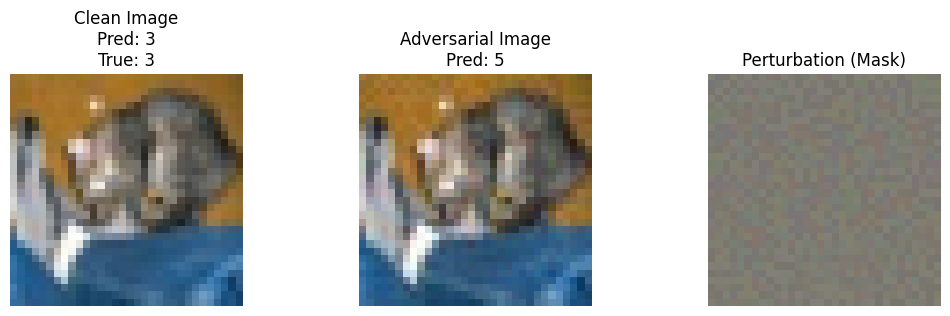

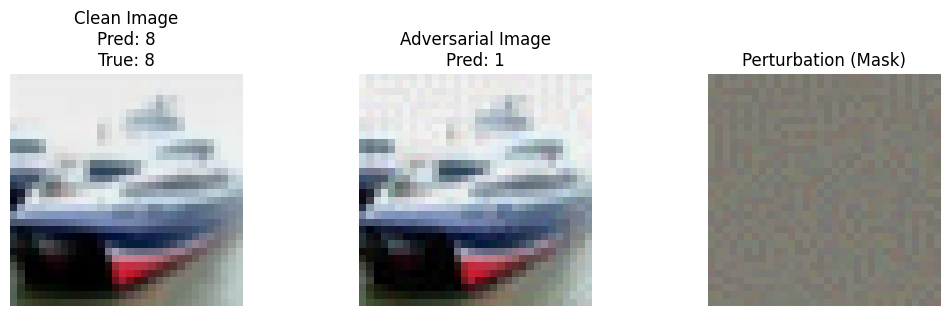

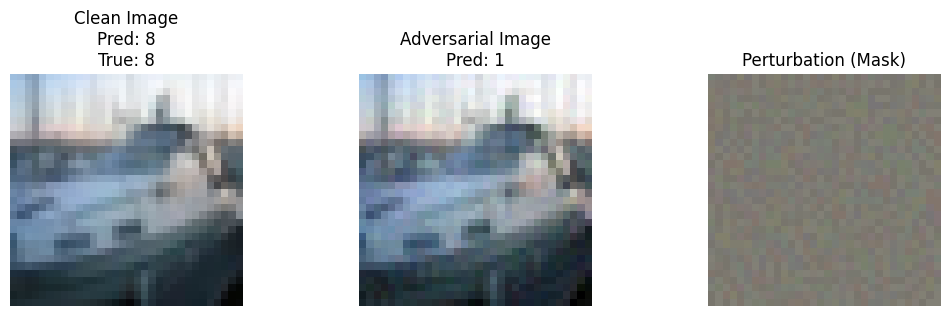

In [14]:
visualize([testset[i] for i in range(0, 3)], attack=pgd)

In [15]:
print(f'Clean data accuracy: {evaluate_attack(None, trainloader):.2f}%')

Clean data accuracy: 100.00%


In [16]:
class AdversarialDataset(torch.utils.data.Dataset):
    def __init__(self, dataloader, model, attack):
        self.adversarial_images = []
        self.labels = []
        self.model = model
        
        model.eval()

        for inputs, labels in tqdm(dataloader, desc="Generating Adversarial Dataset"):
            inputs, labels = inputs.to(device), labels.to(device)

            adv_images = attack(inputs, labels)
        
            self.adversarial_images.extend(list(torch.unbind(adv_images.detach().cpu(), dim=0)))
            self.labels.extend(labels.detach().cpu().tolist())

    def __len__(self):
        return len(self.adversarial_images)

    def __getitem__(self, idx):
        return self.adversarial_images[idx], self.labels[idx]

In [17]:
fgsmset = AdversarialDataset(trainloader, model, fgsm)

Generating Adversarial Dataset: 100%|██████████| 782/782 [00:51<00:00, 15.11it/s]


In [18]:
fgsmloader = torch.utils.data.DataLoader(fgsmset, batch_size=batch_size, shuffle=True)

In [19]:
print(f'FGSM dataset accuracy: {evaluate_attack(None, fgsmloader):.2f}%')

FGSM dataset accuracy: 32.27%


In [20]:
combinedset = torch.utils.data.ConcatDataset([trainset, fgsmset])
combinedloader = torch.utils.data.DataLoader(combinedset, batch_size=batch_size, shuffle=True)

In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [22]:
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    with tqdm(combinedloader, unit="batch") as tepoch:
        tepoch.set_description(f"Epoch [{epoch+1}/{num_epochs}]")
        for inputs, labels in tepoch:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            tepoch.set_postfix(loss=loss.item())

    epoch_loss = running_loss / len(combinedloader)
    print(f"Epoch [{epoch+1}/{num_epochs}] completed. Average Loss: {epoch_loss:.4f}")
model.eval()

Epoch [1/10]:   2%|▏         | 35/1563 [00:03<02:19, 10.93batch/s, loss=1.13] 


KeyboardInterrupt: 

In [26]:
print(f'FGSM dataset accuracy: {evaluate_attack(None, fgsmloader):.2f}%')

FGSM dataset accuracy: 99.00%
